## Sumbit example

In [1495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import metrics

In [1496]:
data = pd.read_csv("train.csv")

In [1497]:
train, test = train_test_split(data, test_size=0.2)

In [1498]:
def print_shape(data):
    shape = data.shape
    print("Rows:", shape[0])
    print("Cols:", shape[1])


In [1499]:
train['date_of_registration'] = pd.to_datetime(train['date_of_registration'])
train['days_since_registration'] = (pd.Timestamp.now() - train['date_of_registration']).dt.days

test['date_of_registration'] = pd.to_datetime(test['date_of_registration'])
test['days_since_registration'] = (pd.Timestamp.now() - test['date_of_registration']).dt.days

In [1500]:
categorial_features = ['category'] # категориальные
real_features = ['average_dwelltime', 'complaints_count', 'days_since_registration', 'buys', 'clicks', '4xx_errors', '5xx_errors', 'likes'] # вещественные
target_features = ['source_attractiveness'] # целевой

In [1501]:
categories = data['category'].unique()
data_categories = data.groupby('category')['source_attractiveness'].max()
print(categories, data_categories)

['ecom' 'information_source' 'news' 'porn' 'social'] category
ecom                  1.355736
information_source    0.578475
news                  0.458114
porn                  0.468389
social                0.507590
Name: source_attractiveness, dtype: float64


In [1502]:
data['complaints_count'] = pd.to_numeric(data['complaints_count'], errors='coerce')

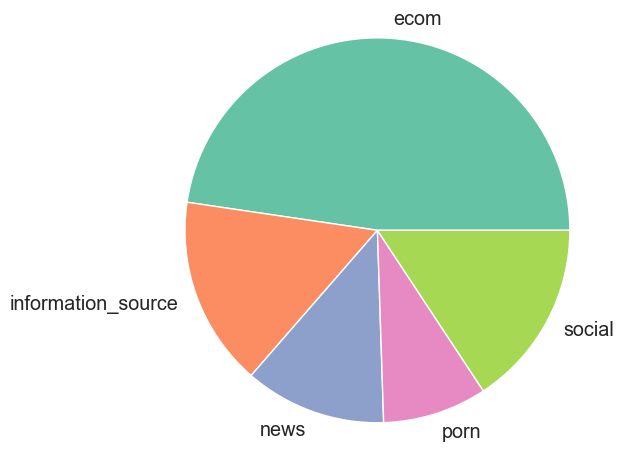

In [1503]:
labels = np.unique(data['category'])

vals = data.groupby('category')['source_attractiveness'].mean()

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
plt.tight_layout()

график показывает, что самая большая средняя оценка по сервисам у категории ecom

<Axes: >

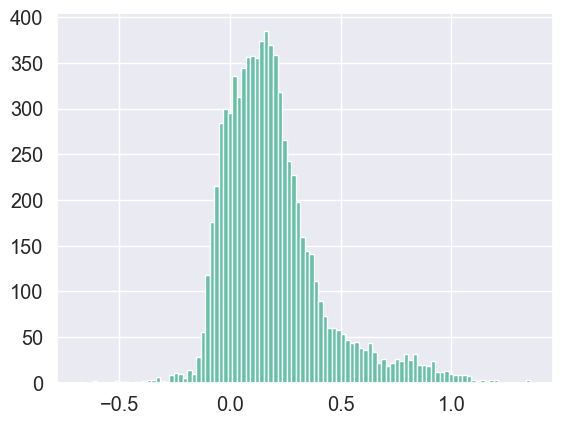

In [1504]:
data['source_attractiveness'].hist(bins=100)

Большинство доменов работаюn продолжительное время

In [1505]:
train[real_features] = train[real_features].apply(pd.to_numeric, errors='coerce')

train[real_features] = train[real_features].fillna(train[real_features].mean())
train[target_features] = train[target_features].fillna(train[target_features].mean())

test[real_features] = test[real_features].apply(pd.to_numeric, errors='coerce')

test[real_features] = test[real_features].fillna(test[real_features].mean())



In [1506]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(train[categorial_features])
test_cat = encoder.transform(test[categorial_features])

In [1507]:
train[real_features] = train[real_features].apply(pd.to_numeric, errors='coerce')
train[real_features] = train[real_features].fillna(train[real_features].mean())

test[real_features] = test[real_features].apply(pd.to_numeric, errors='coerce')
test[real_features] = test[real_features].fillna(test[real_features].mean())

In [1508]:
encoder.categories_

[array(['ecom', 'information_source', 'news', 'porn', 'social'],
       dtype=object)]

In [1509]:
X_train = np.hstack([train[real_features], train_cat])
X_test = np.hstack([test[real_features], test_cat])
y_train = train[target_features].values

In [1510]:
poly = PolynomialFeatures(degree=2)
scaler = StandardScaler()

In [1511]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [1512]:
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

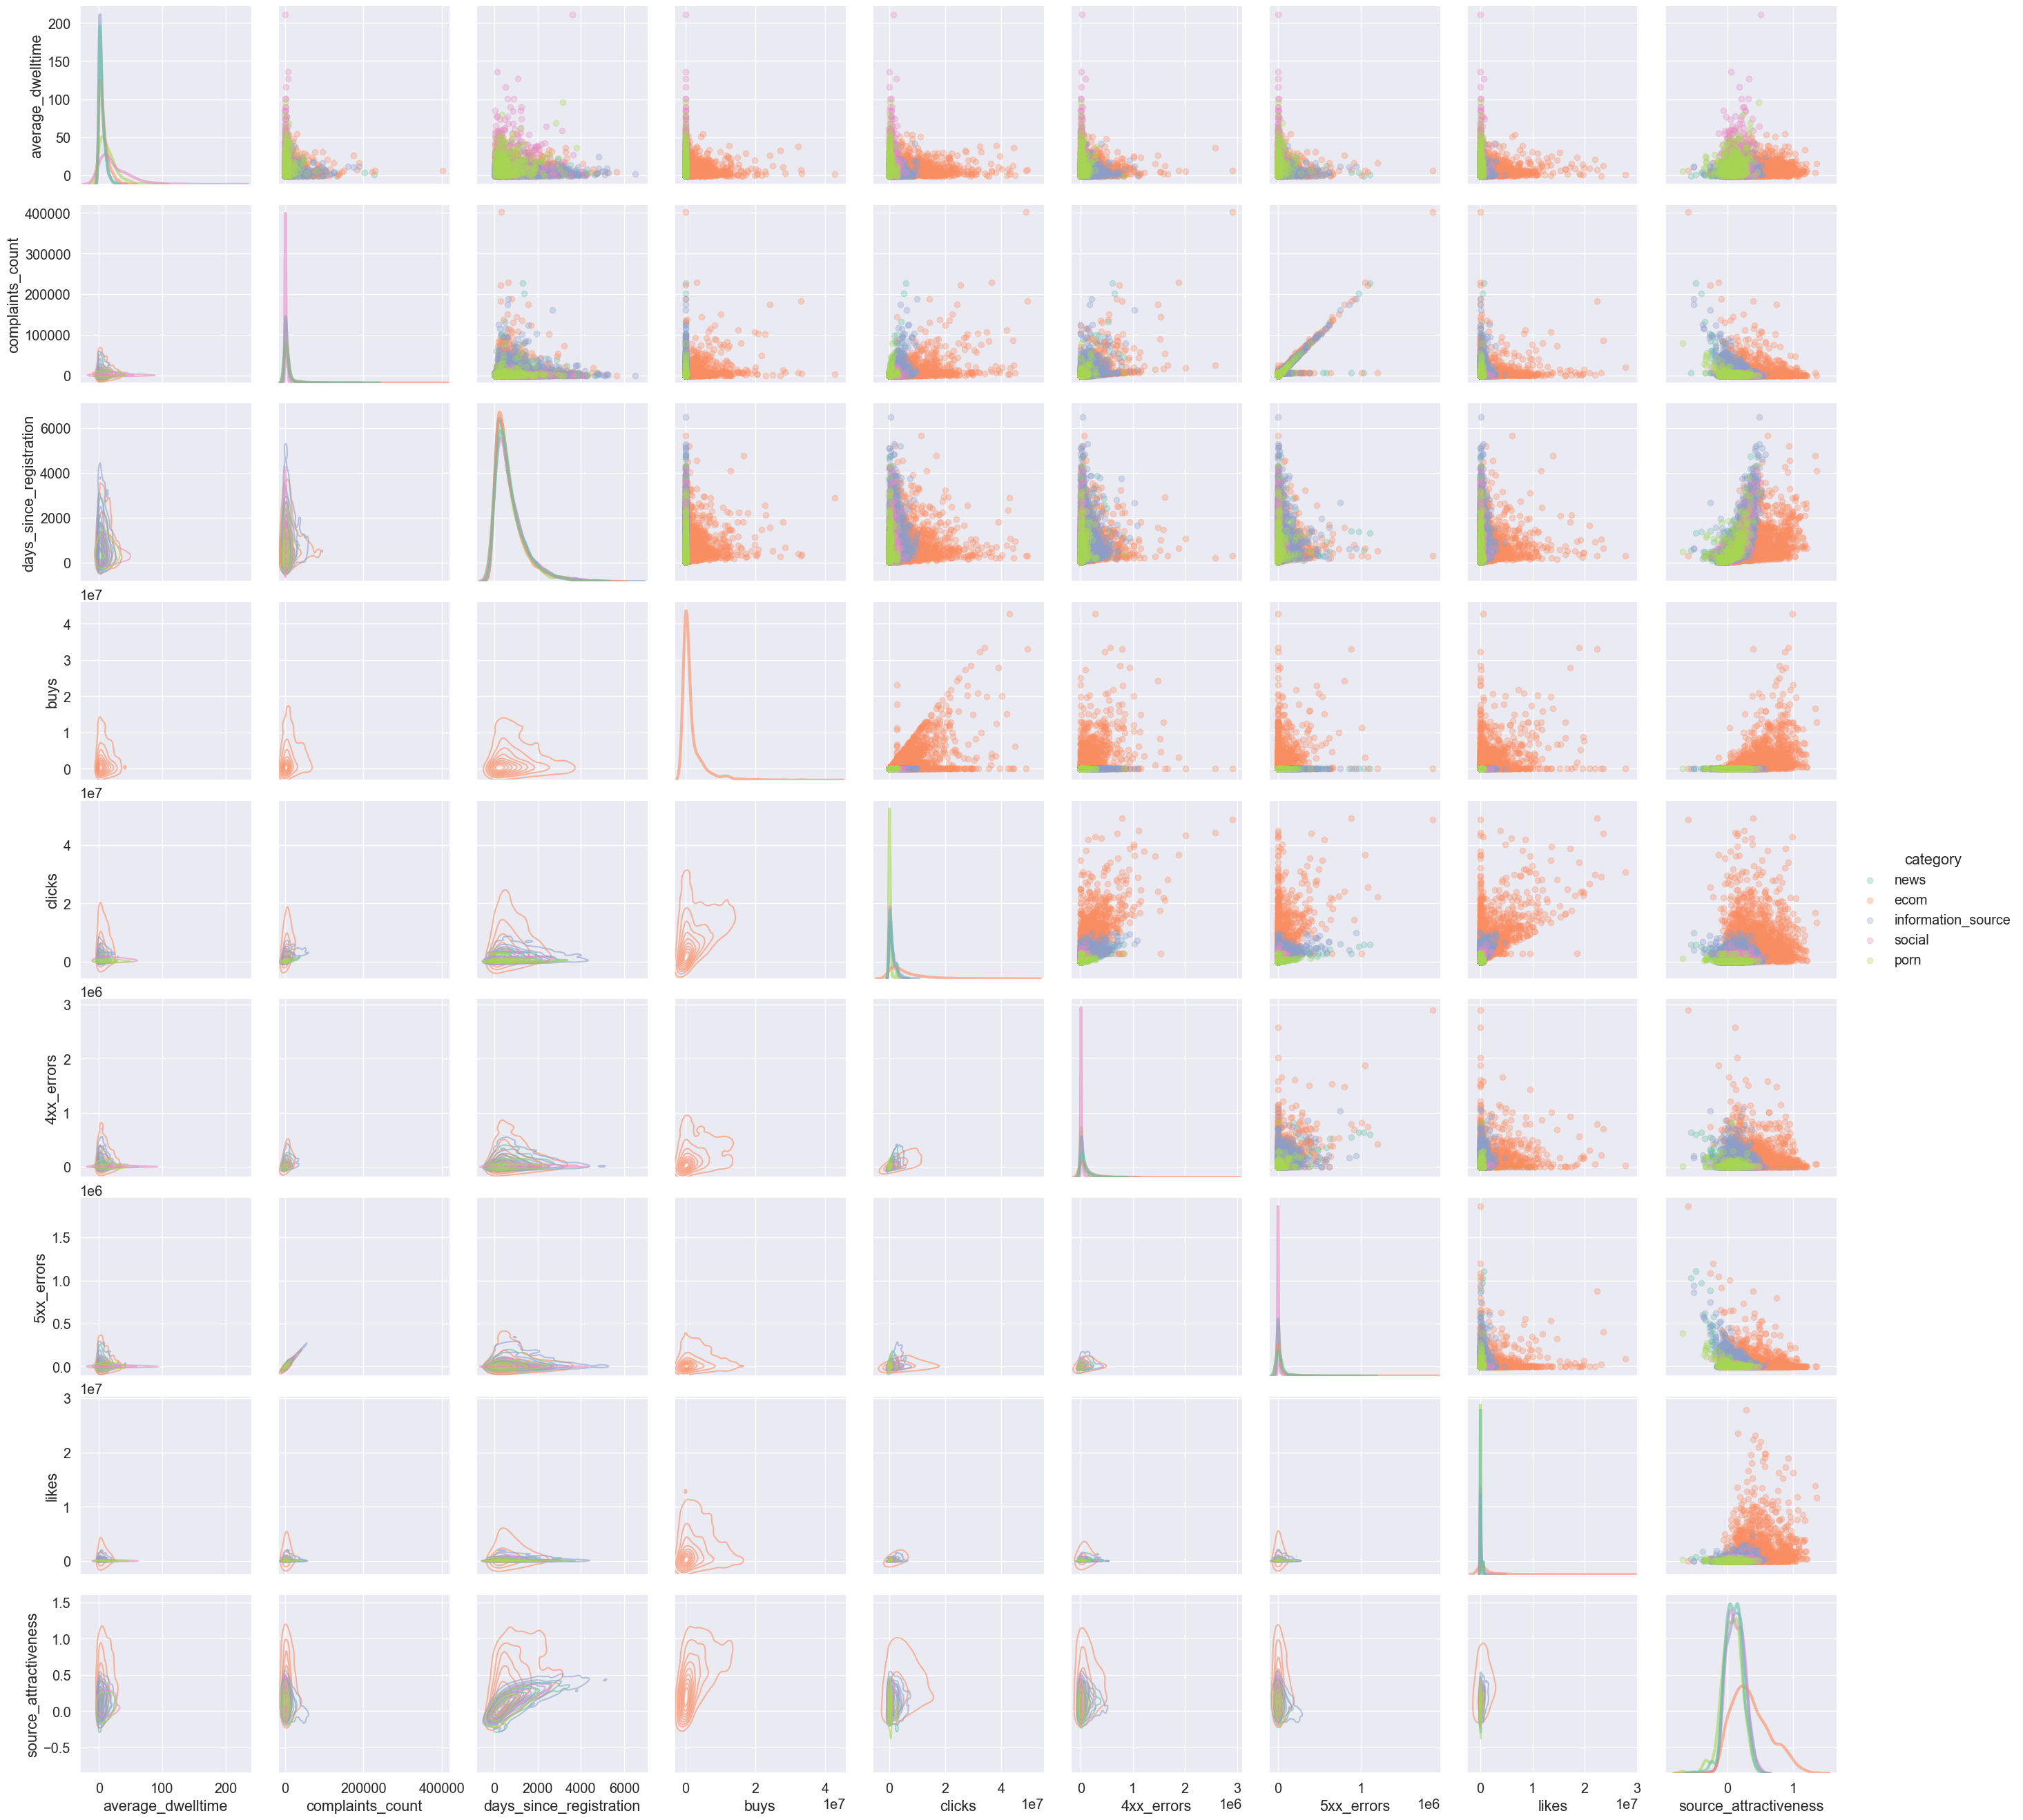

In [1513]:
for hue in categorial_features:
    subset = train[real_features + [target_features[0]] + [hue]].dropna()
    g = sns.PairGrid(subset, hue=hue, diag_sharey=False, height=3)
    g.map_lower(sns.kdeplot, alpha=0.6, warn_singular=False)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False, warn_singular=False)
    g.add_legend()

похоже таргер сильно зависит от количества покупок, а также лайков у домена. Также заметно, что оценка у ecom намного лучше, чем у других категорий. Можно заметить, что 5xxerrors и complaints_count практически линейны, так что откажемся от одного из этих столбцов.

In [1517]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = train[target_features].values[train_index], train[target_features].values[val_index]
    
    best_model = LinearRegression(fit_intercept=True)
    best_model.fit(X_train_fold, y_train_fold)

In [1518]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, train[target_features])

Ridge()

In [1519]:
ridge_preds = ridge_model.predict(X_test)

In [1520]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, train[target_features])

Lasso(alpha=0.1)

In [1521]:
lasso_preds = lasso_model.predict(X_test)

In [1522]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, train[target_features])

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_absolute_error')

In [1523]:
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
test_preds = [item for sublist in test_preds for item in sublist]

In [1524]:
data29 = {
    "source_attractiveness": test_preds
}
submit = pd.DataFrame(data29)
submit.to_csv('submission.csv', index_label="ID")

# Метрики кайф да ура

In [1525]:
metrics.mean_squared_error(test[target_features], test_preds, squared=True),\
metrics.mean_absolute_error(test[target_features], test_preds),\
metrics.mean_absolute_percentage_error(test[target_features], test_preds) * 100,\
metrics.r2_score(test[target_features], test_preds)

/Users/Shy/PycharmProjects/ML/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.012136413899998293,
 0.06893032135342224,
 101.98384700451788,
 0.7817948233980465)